# Michaelis-Menten Model Calibration Example

Author: Caroline Larkin  
Advisor: Dr. James Faeder  
Institution: University of Pittsburgh  
Date: Fall 2022

Based on PTemPest example written in Matlab [here](https://github.com/RuleWorld/ptempest/tree/master/examples/michment)


**Michaelis-Menten Kinetics**  

This system describes the 1) reversible binding of an enzyme to substrate and 2) production of substrate product which is defined in the following scheme:  
$$E + S \rightleftharpoons^{k_f}_{k_r} ES \longrightarrow^{k_{cat}} E + P$$  

Assuming total enzyme concentration is significantly smaller than substrate concentration (i.e., $[E]_T \ll [S]$), the rate is defined as:  
$$\frac{d[P]}{dt} = \frac{k_{cat}[E]_T[S]}{K_M + [S]}$$
where $K_M = \frac{k_{cat} + k_r}{k_f}$

## 1. Set-up Model
### Load relevant packages

In [20]:
import numpy as np
import roadrunner
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math

import pypesto
import pypesto.engine as eng
import pypesto.visualize as visualize
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
from pypesto.ensemble import Ensemble
import os 

SEED=123456
np.random.seed(seed=SEED)
engine = eng.MultiProcessEngine(n_procs=os.cpu_count())

print(os.cpu_count())

# Model system parameters
MODEL_SBML_FILE = "model_sbml.xml"
SPECIES = ["S", "E", "ES", "P"]
SPECIES_IDs = ["S1", "S2", "S3", "S4"] # how the species ids are saved in the SBML file from the original BNGL model
DURATION = 20000
SPECIES_COLORS = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
PARAMS = ["log_k1", "log_k2", "log_k3"]

# Synthetic dataset parameters
PCT_NOISE = 0.01 # % Gaussian noise (range is 0-1)
N_PTS = 20

# Optimization parameters
LOG_ERROR = False

8


### Load model using `libroadrunner`


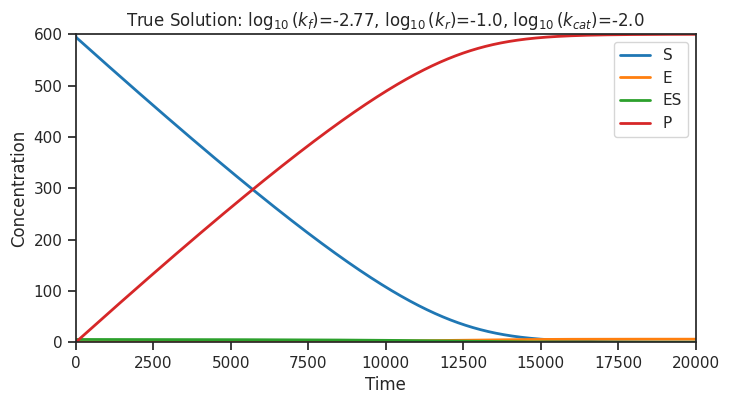

In [21]:
rr = roadrunner.RoadRunner(MODEL_SBML_FILE)
rr.integrator.absolute_tolerance = 5e-10
rr.integrator.relative_tolerance = 1e-8

TRUE_VALS = [rr[PARAMS[0]],rr[PARAMS[1]],rr[PARAMS[2]]]

plt.figure(figsize=(8,4), dpi=100)
res = rr.simulate(0, DURATION, DURATION*10)
ts = res[:, 0]
trajs = np.transpose(res[:, 1:])

for label, color, traj in zip(SPECIES, SPECIES_COLORS, trajs):
    plt.plot(ts, traj, color=color, label=label, lw=2)
plt.legend(); plt.margins(x=0, y=0)
plt.xlabel('Time'); plt.ylabel('Concentration');
title = "True Solution: $\log_{{10}}(k_f)$={k1}, $\log_{{10}}(k_r)$={k2}, $\log_{{10}}(k_{{cat}})$={k3}".format(k1=rr[PARAMS[0]], k2=rr[PARAMS[1]], k3=rr[PARAMS[2]])
plt.title(title); #plt.xscale("log");

### Create synthetic dataset from calibrate model

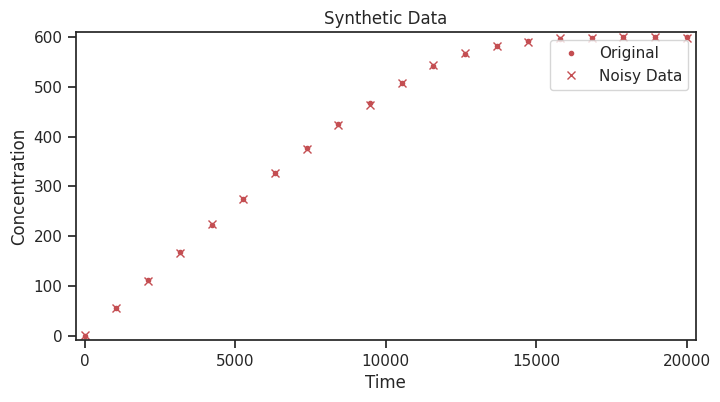

In [22]:
def gaussian_noise(x,std, mu=0):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy

rr.resetAll()
res = rr.simulate(0, DURATION, N_PTS)
ts_data = res[:, 0]
prod_traj = res[:, -1]

std = PCT_NOISE * np.std(prod_traj)
noisy_data = gaussian_noise(prod_traj, std)

# Plot noisy data
plt.figure(figsize=(8,4), dpi=100)
plt.plot(ts_data, prod_traj, 'r.', label="Original")
plt.plot(ts_data, noisy_data, 'rx', label="Noisy Data")
plt.legend(); plt.margins(x=0.015, y=0.015)
plt.xticks([0, 0.5*1e4, 1e4,1.5*1e4, 2*1e4])
plt.xlabel('Time'); plt.ylabel('Concentration');
plt.title('Synthetic Data'); #plt.xscale("log");

# Save for later
df = pd.DataFrame()
df['Time'] = ts_data
df['Product'] = noisy_data
df.to_csv('synthetic_mm_data.csv', index=False)

### Define helper functions that change model parameters and simulate model


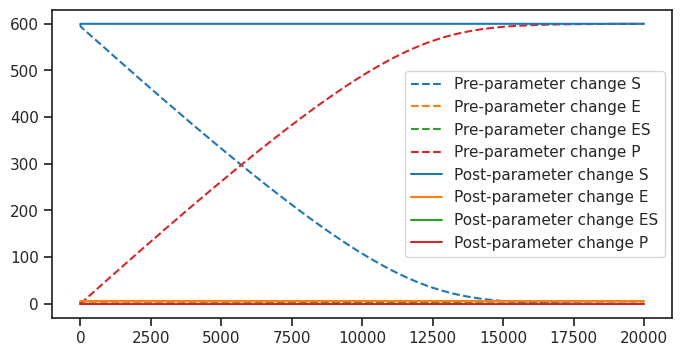

In [23]:
def change_and_run(new_params):
    rr.resetAll()
    for name,val in zip(PARAMS, new_params):
        rr[name] = val
        rr.reset() # This forces assignment rules in the SBML model to be re-evaluated
        #print(name, val, rr[name])
    try:
        res = rr.simulate(0, DURATION, N_PTS)
        #print(res)
    except:
        res = []
    return np.asarray(res)

rr.resetAll()
plt.figure(figsize=(8,4), dpi=100)
orig_traj = rr.simulate(0, DURATION, N_PTS*100)
orig_ts = orig_traj[:, 0]

orig_specs = np.transpose(orig_traj[:, 1:])
for cur_label, cur_traj, cur_c in zip(SPECIES, orig_specs, SPECIES_COLORS):
    plt.plot(orig_ts, cur_traj, c=cur_c, label="Pre-parameter change %s"%cur_label, linestyle="--")
plt.legend();

# sanity check by setting all parameters to near 0
traj = change_and_run([-10, -10, -10])
traj_ts = traj[:, 0]
traj_specs = np.transpose(traj[:, 1:])

for cur_label, cur_traj, cur_c in zip(SPECIES, traj_specs, SPECIES_COLORS):
    plt.plot(traj_ts, cur_traj, c=cur_c, label="Post-parameter change %s"%cur_label)
plt.legend();

### Define cost function


In [24]:
def cost_fun(params):
    candidate_params = copy.deepcopy(params)    
    res_guess = change_and_run(candidate_params)

    if np.isnan(res_guess).any() or not np.any(res_guess):
        return np.inf
    
    ts_guess = res_guess[:, 0]
    p_guess = res_guess[:, -1] # product 

    #print(ts_data, '\n', ts_guess[:10])
    t_idxs = np.array([i for i in range(len(ts_guess)) for j in range(len(ts_data)) if math.isclose(ts_guess[i],ts_data[j])])
    
    if t_idxs.shape[0] != ts_data.shape[0]:
        print(t_idxs.shape[0], ts_data.shape[0])
        raise Exception('Not all the times outputted by candidate parameter system are found in data time points! We cannot calculate error!')
    
    p_guess_short = p_guess[t_idxs]
    # need to cast square difference as a numpy array otherwise the returned sse will be returned as a librr object which causes issues when saving in h5 file via pypesto
    sse = np.sum(np.asarray(np.square(noisy_data - p_guess_short)))
    
    if LOG_ERROR:
        sse = np.log10(sse)
        
    return sse
    
# sanity check should be less than poor solution error
print("True solution error: ", cost_fun(TRUE_VALS), type(cost_fun(TRUE_VALS)))

print("Poor solution error: ", cost_fun([10,10,10]), type(cost_fun([10,10,10])))

True solution error:  67.64960755294125 <class 'numpy.float64'>
Poor solution error:  1159716.513176834 <class 'numpy.float64'>


## 2. Optimization
### Set up pyPESTO objective and corresponding problem

In [25]:
error = pypesto.Objective(fun=cost_fun)

bnds = np.log10([(1e-3, 1e1), (1e-1, 1e3), (1e-3, 1e3)])
print(bnds)
lb = [x[0] for x in bnds]; ub = [x[1] for x in bnds];
problem = pypesto.Problem(
    objective=error,
    lb=lb,
    ub=ub,
)

[[-3.  1.]
 [-1.  3.]
 [-3.  3.]]


### Run multistart local optimization

In [26]:
history_options = pypesto.HistoryOptions(trace_record=True)
optim_nm = optimize.ScipyOptimizer(
    method='Nelder-Mead', 
    options={'maxiter':int(1e3)}
)

result = optimize.minimize(
    problem=problem,
    optimizer=optim_nm,
    n_starts=100,
    filename=None, engine=engine,
    progress_bar=True, history_options=history_options
)

Performing parallel task execution on 8 processes.
100%|██████████| 100/100 [00:11<00:00,  9.05it/s]


<AxesSubplot: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=-5.704e+01)'>

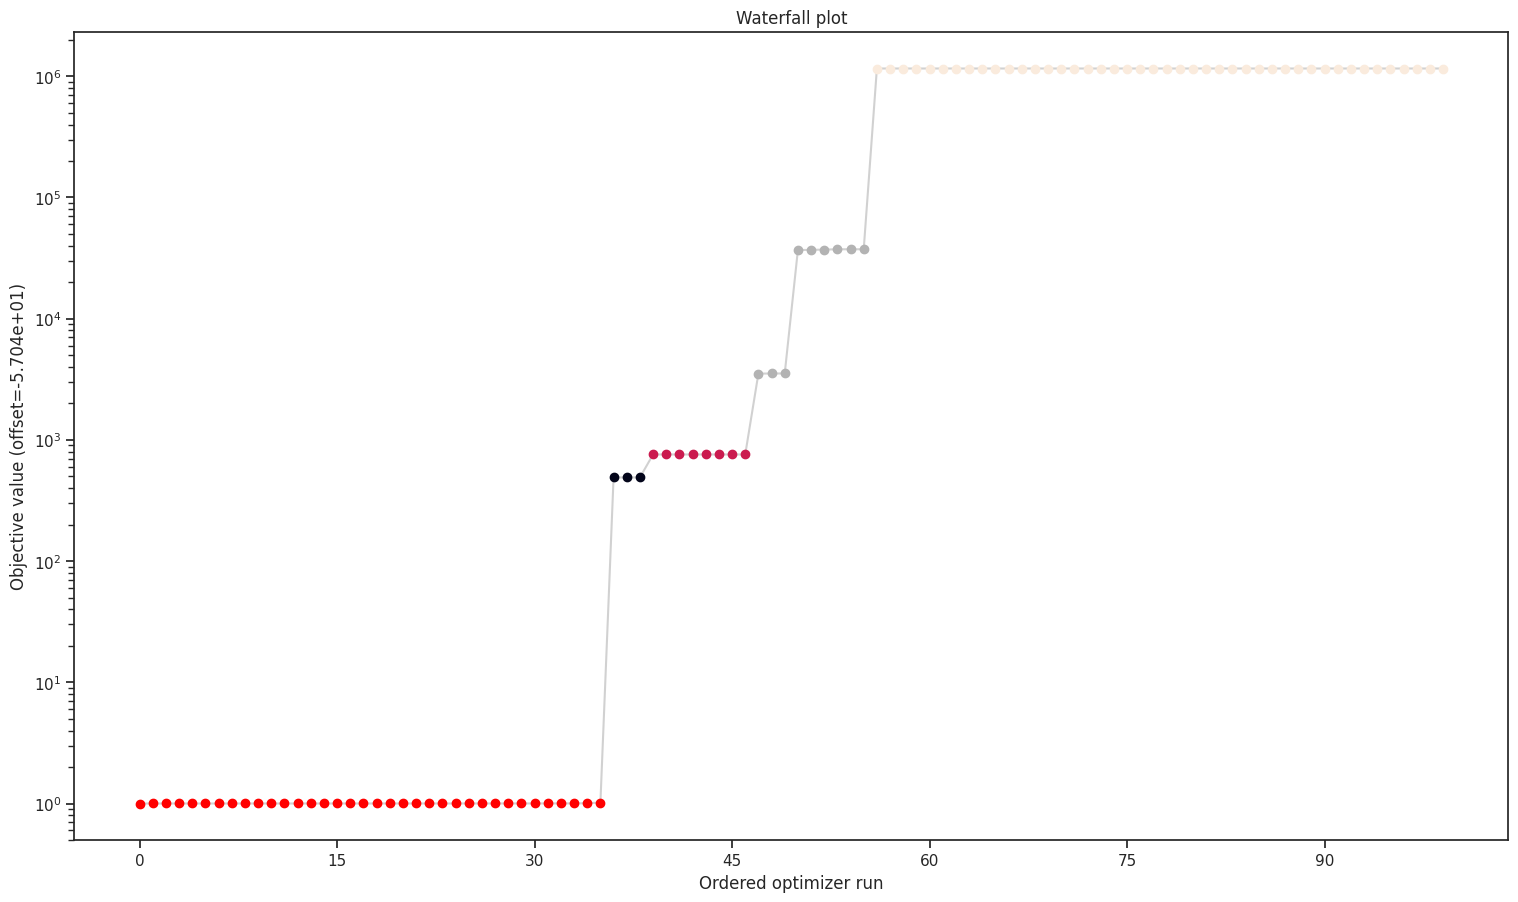

In [27]:
visualize.waterfall(result)

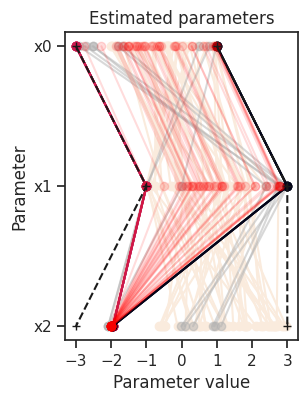

In [28]:
visualize.parameters(result, size=(3,4));

### Run MCMC sampling

In [29]:
n_samps = 500000
internal_sampler = sample.MetropolisSampler({'std':0.003})
sampler = sample.ParallelTemperingSampler(internal_sampler=internal_sampler, n_chains=4)
result = sample.sample(
    problem=problem, 
    n_samples=n_samps, 
    result=result, 
    sampler=sampler,
    filename=None
)
elapsed_time = result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")

print(result.sample_result.keys())
print(result.sample_result['burn_in'])

100%|██████████| 500000/500000 [54:19<00:00, 153.38it/s] 
Elapsed time: 3264.025705209


Elapsed time: 3264.03
dict_keys(['trace_x', 'trace_neglogpost', 'trace_neglogprior', 'betas', 'burn_in', 'time', 'auto_correlation', 'effective_sample_size', 'message'])
None


## 3. Save (and reload) results

In [30]:
store.write_result(result, 'mm_test.hdf5', overwrite=True, optimize=True, problem=True, sample=True)

In [31]:
results_fn = "mm_test.hdf5"
result = store.read_result(results_fn, problem=True, optimize=True, sample=True)

This problem is not to be used without a separately created objective.


In [32]:
optim_df = result.optimize_result.as_dataframe()
optim_df

,id,x,fval,grad,hess,res,sres,n_fval,n_grad,n_hess,n_res,n_sres,x0,fval0,history,exitflag,time,message,optimizer
0,55,"[0.9539345062014615, 2.7527485526841913, -2.00...",5.804335e+01,None,None,None,None,221,0,0,0,0,"[-2.120300872863706, 1.5444067898704668, -1.98...",2.890023e+06,None,0,0.719800,Optimization terminated successfully.,<ScipyOptimizer method=Nelder-Mead options={'m...
1,94,"[0.9993085707391771, 2.7980987247888676, -2.00...",5.804338e+01,None,None,None,None,327,0,0,0,0,"[-1.2103168404926206, 1.2311683225800651, -0.4...",1.158157e+06,None,0,0.535299,Optimization terminated successfully.,<ScipyOptimizer method=Nelder-Mead options={'m...
2,25,"[0.9563777198865473, 2.7551660368954973, -2.00...",5.804338e+01,None,None,None,None,338,0,0,0,0,"[-2.002735940825675, 2.972495931311357, -2.814...",4.150206e+06,None,0,0.953392,Optimization terminated successfully.,<ScipyOptimizer method=Nelder-Mead options={'m...
3,7,"[0.6085852756137042, 2.407390449010543, -2.003...",5.804339e+01,None,None,None,None,233,0,0,0,0,"[-0.19126255607781495, 0.6561346584715473, -0....",1.159701e+06,None,0,0.911925,Optimization terminated successfully.,<ScipyOptimizer method=Nelder-Mead options={'m...
4,92,"[0.8958872180201711, 2.6947316055730823, -2.00...",5.804340e+01,None,None,None,None,127,0,0,0,0,"[0.44174803382234407, 2.1037959728321933, -2.9...",3.018349e+06,None,0,0.419883,Optimization terminated successfully.,<ScipyOptimizer method=Nelder-Mead options={'m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,40,"[0.8793603017757903, 1.382427208957209, -0.508...",1.159717e+06,None,None,None,None,68,0,0,0,0,"[0.8695864011252823, 1.366853238162304, -0.489...",1.159717e+06,None,0,0.288562,Optimization terminated successfully.,<ScipyOptimizer method=Nelder-Mead options={'m...
96,38,"[-0.352737315944592, 0.09850532932712802, -0.4...",1.159717e+06,None,None,None,None,55,0,0,0,0,"[-0.3446593621443341, 0.09595648518928757, -0....",1.159717e+06,None,0,0.207147,Optimization terminated successfully.,<ScipyOptimizer method=Nelder-Mead options={'m...
97,43,"[0.9600122252729775, 1.1426409322412554, 0.373...",1.159717e+06,None,None,None,None,70,0,0,0,0,"[0.9600122252729775, 1.1426409322412554, 0.355...",1.159717e+06,None,0,0.276288,Optimization terminated successfully.,<ScipyOptimizer method=Nelder-Mead options={'m...
98,51,"[0.9151772391020588, 0.9952523713221414, -0.62...",1.159717e+06,None,None,None,None,76,0,0,0,0,"[0.9239461726854157, 0.9528308142376414, -0.62...",1.159717e+06,None,0,0.454968,Optimization terminated successfully.,<ScipyOptimizer method=Nelder-Mead options={'m...


## 4. Visualization
### Local optimization result visualization

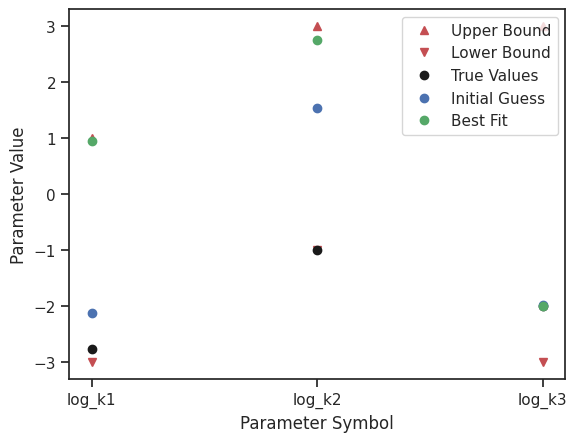

In [33]:
param_labels = PARAMS
true_vals = TRUE_VALS

local_optim = optim_df.iloc[0, :]

best_params = local_optim['x']
init_params = local_optim['x0']

best_err = local_optim['fval']
init_err = local_optim['fval0']

plt.plot(param_labels, ub, 'r^', label='Upper Bound')
plt.plot(param_labels, lb, 'rv', label='Lower Bound')
plt.plot(param_labels, true_vals, 'ko', label="True Values");
plt.plot(param_labels, init_params, 'bo', label="Initial Guess")
plt.plot(param_labels, best_params, 'go', label='Best Fit')
plt.legend();
plt.xlabel('Parameter Symbol'); plt.ylabel('Parameter Value');

### Sampling result visualization

/home/cil8/anaconda3/lib/python3.9/site-packages/pypesto/visualize/sampling.py:1278: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  warnings.warn(


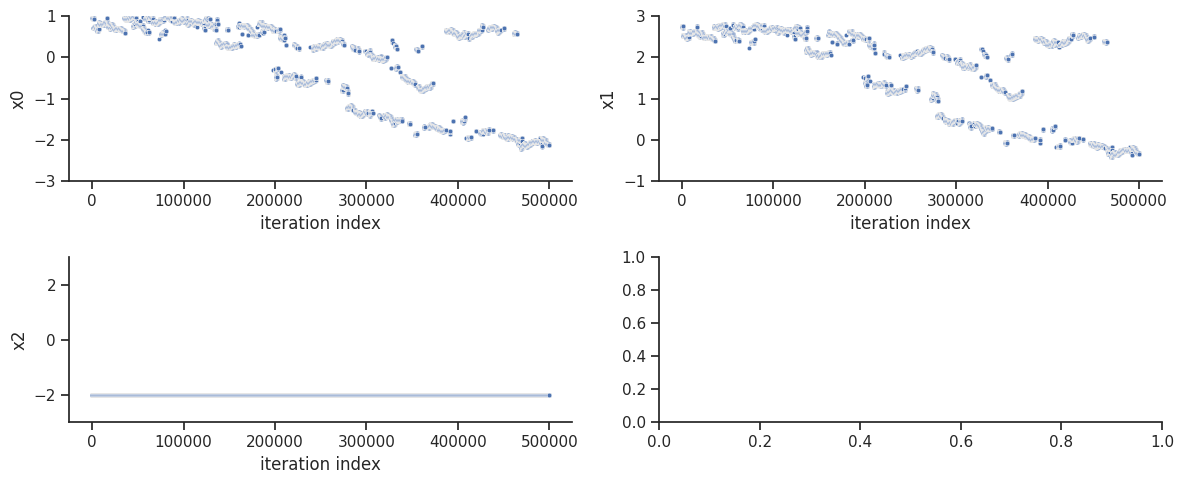

In [34]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=True, size=(12, 5)
)

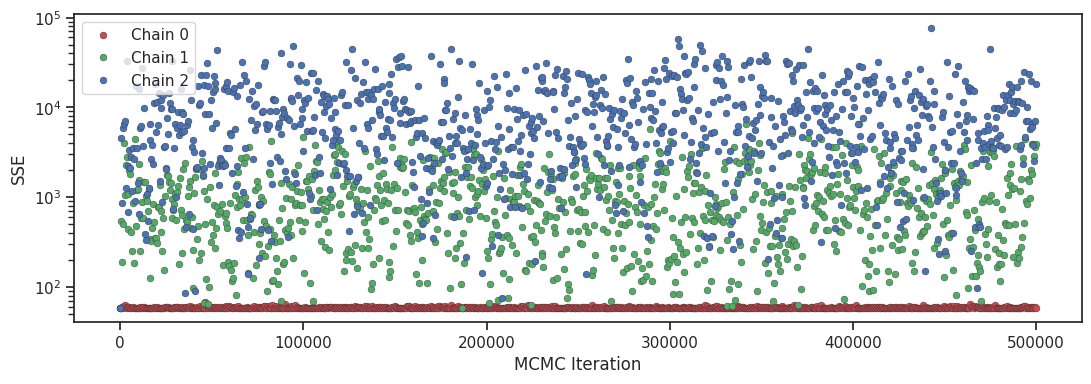

In [35]:
post = result.sample_result['trace_neglogpost']

STEP = 500
plt.figure(figsize=(13,4));
colors = ['r', 'g', 'b']

# iterate through each chain
for i, c, cur_post in zip(np.arange(post.shape[0]), colors, post):
    plt.plot(np.arange(1,len(cur_post)+1)[::STEP], cur_post[::STEP], 'o', markersize=5, color=c, markeredgecolor='k', markeredgewidth=0.2, label="Chain %d"%i)
plt.legend(); plt.yscale('log');
plt.ylabel('SSE'); plt.xlabel('MCMC Iteration');

In [36]:
sample.geweke_test(result=result)

Geweke burn-in index: 375000


375000

In [37]:
def calc_acceptance(samp_result):
    params = samp_result['trace_x'][0]
    accept = [0 if (params[i, :] == params[i-1, :]).all() else 1 
              for i in range(1, params.shape[0])]
    num_accept = np.sum(accept)
    rate = num_accept / (params.shape[0] - 1)
    return rate

accept_rate = calc_acceptance(result.sample_result)
print("The acceptance rate of MCMC is %.4f%%"%(accept_rate*100))

The acceptance rate of MCMC is 11.6190%


In [38]:
time = result.sample_result.time
sample.effective_sample_size(result=result)
ess = result.sample_result.effective_sample_size
print(
    f"Effective sample size per computation time: {round(ess/time,5)}"
)

Estimated chain autocorrelation: 13798.719051467478
Estimated effective sample size: 9.058227891002407


Effective sample size per computation time: 0.00278


In [39]:
# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    x_names=PARAMS,
    remove_burn_in=True,
    lower_bound=lb,
    upper_bound=ub,
)

ensemble.check_identifiability()

,parameterId,lowerBound,upperBound,ensemble_mean,ensemble_std,ensemble_median,within lb: 1 std,within ub: 1 std,within lb: 2 std,within ub: 2 std,within lb: 3 std,within ub: 3 std,within lb: perc 5,within lb: perc 20,within ub: perc 80,within ub: perc 95
parameterId,,,,,,,,,,,,,,,,
log_k1,log_k1,-3.0,1.0,-0.915187,1.257719,-0.915187,True,True,False,False,False,False,True,True,True,True
log_k2,log_k2,-1.0,3.0,0.879708,1.260687,0.879708,True,True,False,False,False,False,True,True,True,True
log_k3,log_k3,-3.0,3.0,-2.003447,0.001254,-2.003447,True,True,True,True,True,True,True,True,True,True


In [40]:
# simple wrapper to calculate predict product trajectory given candidate parameter set
def predict(params):
    res = change_and_run(params)
    guess_p = res[:, -1]
    return guess_p

trajs = [predict(x) for x in np.transpose(ensemble.x_vectors)]

In [41]:
trajs = np.array(trajs)
print(trajs.shape)
means = np.mean(trajs, axis=0)
print(means.shape)

(125001, 20)
(20,)


# Calculate confidence intervals using entire ensemble

In [42]:
import scipy.stats as st

ci = 0.95
intervals = np.array(st.norm.interval(alpha=ci, loc=np.mean(trajs, axis=0), scale=np.std(trajs, axis=0)))
print(intervals.shape)

ci2 = 0.9999
intervals2 = np.array(st.norm.interval(alpha=ci2, loc=np.mean(trajs, axis=0), scale=np.std(trajs, axis=0)))

intervals[:, 0] = [0,0]
intervals2[:, 0] = [0,0]

(2, 20)


/home/cil8/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/cil8/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


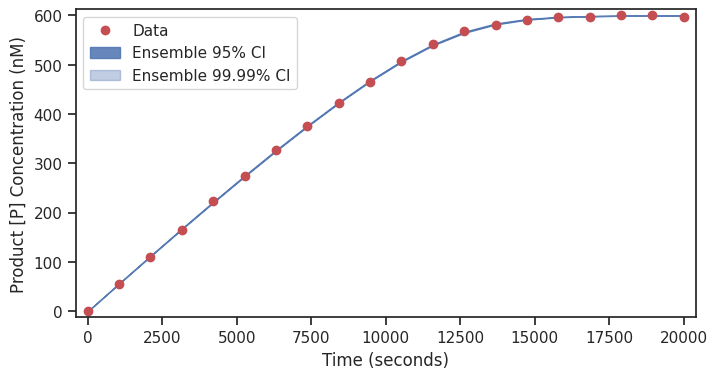

In [43]:
plt.figure(figsize=(8,4), dpi=100)

# plot experimental data
plt.plot(ts_data, noisy_data, 'ro', label='Data')

# plot ensemble predictions
plt.fill_between(ts_data, intervals[0, :], intervals[1, :], alpha=0.85, color='b', label="Ensemble {pct:n}% CI".format(pct=ci*100))
plt.fill_between(ts_data, intervals2[0, :], intervals2[1, :], alpha=0.35, color='b', label="Ensemble {pct:n}% CI".format(pct=ci2*100))

plt.xlabel("Time (seconds)"); plt.ylabel("Product [P] Concentration (nM)");
plt.margins(x=0.02, y=0.02); plt.legend();

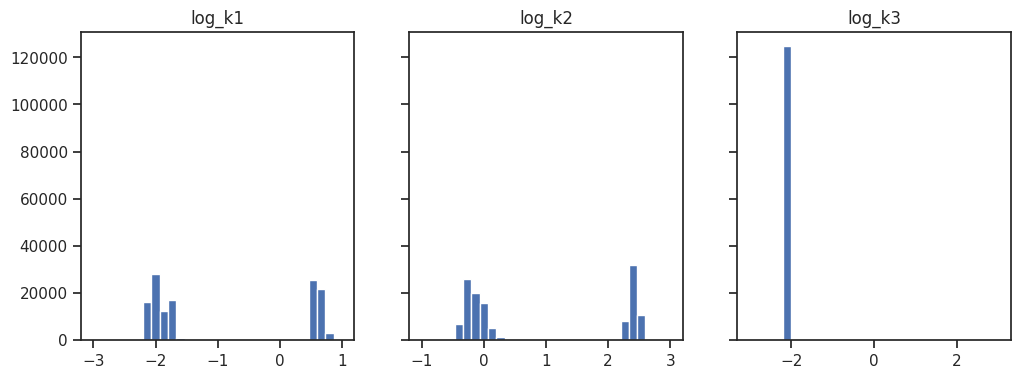

In [44]:
samps = ensemble.x_vectors
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=True) 

ax1.hist(samps[0, :], range=bnds[0, :], bins=30); ax1.set_title(PARAMS[0]);
ax2.hist(samps[1, :], range=bnds[1, :], bins=30); ax2.set_title(PARAMS[1]);
ax3.hist(samps[2, :], range=bnds[2, :], bins=30); ax3.set_title(PARAMS[2]);

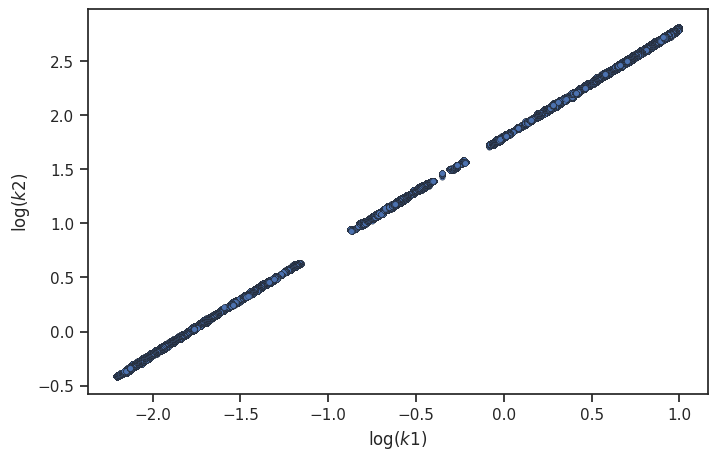

In [45]:
ensemble = Ensemble.from_sample(
    result,
    x_names=PARAMS,
    remove_burn_in=False,
    lower_bound=lb,
    upper_bound=ub,
)
samps = ensemble.x_vectors

plt.figure(figsize=(8,5), dpi=100)
plt.plot(samps[0, :], samps[1, :], 'bo', markersize=4, markeredgecolor='k', markeredgewidth=0.2);
plt.xlabel('$\log(k1)$'); plt.ylabel('$\log(k2)$');